# Solver verification for the flexure of a floating beam with one free end

This notebook tests the numerical solutions for the case of an ice shelf terminating in a cliff (in which case the terminal imbalance forces the terminus downward, with a smaller upward deflection some distance back from the terminus). For the elastic floating beam setup, the fourth-order problem to be solved is 

$$\frac{\partial^4\eta}{\partial x^4} = -\frac{12(1 - \mu^2)}{EH^3}\rho_wg\eta,$$

and for the viscous floating beam, 

$$\frac{\partial^4\dot{\eta}}{\partial x^4} = -\frac{3}{\nu_fH^3}\rho_wg\dot{\eta}\Delta t,$$

where the physical constants are defined two cells below. Solutions are of the form

$$\eta \text{ (or } \dot{\eta}) = C_1e^{Dx}\sin(Dx) + C_2e^{-Dx}\sin(Dx) + C_3e^{Dx}\cos(Dx) + C_4e^{-Dx}\cos(Dx),$$ 

where $D := \sqrt[4]{\frac{3(1 - \mu^2)}{EH^3}\rho_wg}$ in the elastic case, or $\sqrt[4]{\frac{3}{4\nu_fH^3}\rho_wg\Delta t}$ in the viscous case, and $C_i$ are constants which can be determined by setting appropriate boundary conditions. 

## Imports

In [1]:
flexure_type = 'viscous' #can be 'viscous', or 'elastic'
path = f'/home/sermilik/H3F/figures/ice_foot_{flexure_type}' #modify to preferred destination for saving figures

from firedrake import *
import matplotlib.pyplot as plt
import numpy as np
from operator import itemgetter
import os
import tqdm

os.chdir(path) #for saving figures

## Physical constants

In [2]:
year = 60*60*24*365.25 #number of seconds in a year
ρ_i = 917 #icepack's default is 917 kg/m^3
ρ_w = 1024 #icepack's default is 1024 kg/m^3
ϱ = ρ_i/ρ_w #density ratio
g = 9.81 #gravity in N/kg
E = 1e9 #Young's Modulus in Pascals
μ = 1/3 #Poisson's Ratio
ν_flex = 5e15/year #flexural viscosity, Pa*s to Pa*yrs

λ_1 = E/(1 + μ) #convenient shorthand variable (Lame parameters)
λ_2 = E/(1 + μ)*μ/(1 - μ) #convenient shorthand variable

H_gl = 100 #thickness at upstream boundary (m)
Δt = 1/2 #timestep in years; only matters for viscous solution

# Meshing

I'll set the length of the shelf to $L = \frac{2m\pi}{D}$ for some positive integer $m$. This makes the constants of integration way nicer to evaluate in the analytic solutions, since sines are now 0 and cosines are now 1 at either boundary. Given the material constants set above, $m = 3$ or $4$ results in a domain length of 10 km or so. 

In [3]:
D = sqrt(sqrt((3*ρ_w*g*(1 - μ**2)/(E*H_gl**3)))) if flexure_type == 'elastic' else sqrt(sqrt(3*ρ_w*g*Δt/(4*ν_flex*H_gl**3)))
m = 1
print(f'L = {2*m*pi/D:.2f} meters')

nx, ny = 200, 1 #one single element in the y direction for a 1D-ish problem (unfortunately, Argyris elements are triangles...)
Lx, Ly = 2*m*pi/D, 1000 #length in x, y
mesh = RectangleMesh(nx, ny, Lx, Ly)
x, y = SpatialCoordinate(mesh)

Q1 = FunctionSpace(mesh, 'Argyris', 5) #Argyris elements for solving 4th order flexure problem
Q2 = FunctionSpace(mesh, 'CG', 2) #CG elements for visualizing the solutions

η_e, η_ν = Function(Q1), Function(Q1) #elastic deflection; viscous deflection rate
w_e, w_ν = TestFunction(Q1), TestFunction(Q1)
Δw_e, Δw_ν = div(grad(w_e)), div(grad(w_ν)) 
ddw_e, ddw_ν = grad(grad(w_e)), grad(grad(w_ν))

L = 2845.42 meters


## Initialize some solver choices

In [4]:
################################
################################
### parameters for iteration ###
################################
################################

num_timesteps = 1 #for now just solve the static problem (do not iterate)
α = 1e10 #arbitrary large number for penalty method

###################################
####################################
### initialize flexure solutions ###
####################################
####################################

Ση_e, Ση_νΔt = Function(Q2).project(Constant(0)), Function(Q2).project(Constant(0)) #net elastic and viscous deflections
Ση = Function(Q2).project(Constant(0)) #net elastic PLUS viscous deflections
τ_ν, σ_e = Function(Q2).project(Constant(0)), Function(Q2).project(Constant(0)) #bending stresses

###############################
###############################
### define initial geometry ###
###############################
###############################

s = Function(Q2).project(Constant((1 - ϱ)*H_gl))
b = Function(Q2).project(Constant(-ϱ*H_gl))
H = Function(Q2).project(Constant(H_gl))
X = np.array([(k, Ly/2) for k in range (0, int(Lx+1))]) #along-flow line for getting geometry profiles

## Choose boundary conditions and determine the analytic solution

Assume that there is neither deflection nor bending at the upstream boundary, no shear force acting on the cliff boundary, and a prescribed deflection $\eta_0$ at the cliff. In the elastic case, this means that $\eta(0) = \eta''(0) = \eta'''(L) = 0; \eta(L) = \eta_0$. In the viscous case, $\dot{\eta}(0) = \dot{\eta}''(0) = \dot{\eta}'''(L) = 0$ and $\dot{\eta}(L) = \frac{\eta_0}{\Delta t}$ (so, in the viscous case, the corresponding deflection *rate* at the cliff will depend on the timestep chosen). The solution to the elastic problem is 

$$\eta = \frac{\eta_0}{e^{DL} - e^{-DL}}\left(e^{Dx}\sin(Dx) + e^{-Dx}\sin(Dx) + e^{Dx}\cos(Dx) - e^{-Dx}\cos(Dx)\right)$$ 

and the solution to the viscous problem is

$$\dot{\eta} = \frac{\eta_0}{(e^{DL} - e^{-DL})\Delta t}\left(e^{Dx}\sin(Dx) + e^{-Dx}\sin(Dx) + e^{Dx}\cos(Dx) - e^{-Dx}\cos(Dx)\right)$$ 


However, when solving numerically, I'm unable to constrain $\eta'''$. Not sure why. For verification purposes, I can use the analytic solutions to obtain corresponding conditions in the first derivatives. For example, in the elastic case, the analytic solution guarantees that $\eta'(L) = 2D\eta_0\left(\frac{e^{DL} + e^{-DL}}{e^{DL} - e^{-DL}}\right)$; in the viscous case, $\dot{\eta}'(L) = \frac{2D\eta_0}{\Delta t}\left(\frac{e^{DL} + e^{-DL}}{e^{DL} - e^{-DL}}\right)$. I'll use these as a boundary conditions instead of $\eta'''(L) = 0$ or $\dot{\eta}'''(L) = 0$. But in general it would be great to be able to enforce conditions on $\eta'''$. 

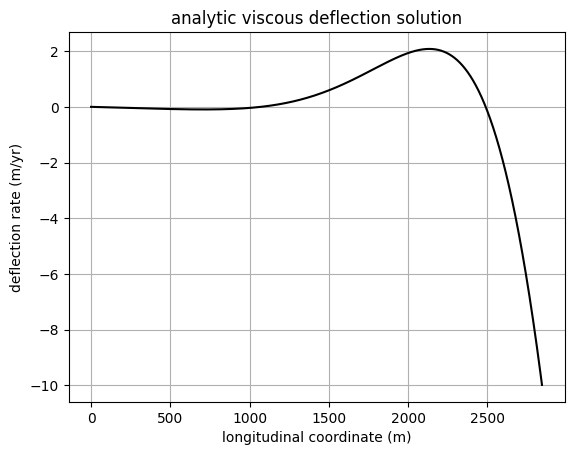

In [5]:
η_0 = -5 #boundary value for the deflection (m) at the terminal cliff 

C_1 = η_0/(exp(D*Lx) - exp(-D*Lx)) if flexure_type == 'elastic' else η_0/((exp(D*Lx) - exp(-D*Lx))*Δt)
analytic = Function(Q2).project(C_1*(exp(D*x)*sin(D*x) + exp(-D*x)*sin(D*x) + exp(D*x)*cos(D*x) - exp(-D*x)*cos(D*x)))
analytic_profile = analytic.at(X, tolerance = 1e-10)

##############################
##############################
### plot analytic solution ###
##############################
##############################

plt.figure()
plt.title(f'analytic {flexure_type} deflection solution')
plt.plot(analytic_profile, color = 'k')
plt.grid()
plt.xlabel('longitudinal coordinate (m)')
if flexure_type == 'elastic':
    plt.ylabel('deflection (m)')
elif flexure_type == 'viscous':
    plt.ylabel('deflection rate (m/yr)')
plt.show()

## Solve the problem numerically

I've attempted to include constaints in $\eta'''$ on lines 30 and 72. These end up not being enforced by the solver. Instead, I use constraints in $\eta'$ (see the discussion above), on lines 33 and 75.

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.64s/it]


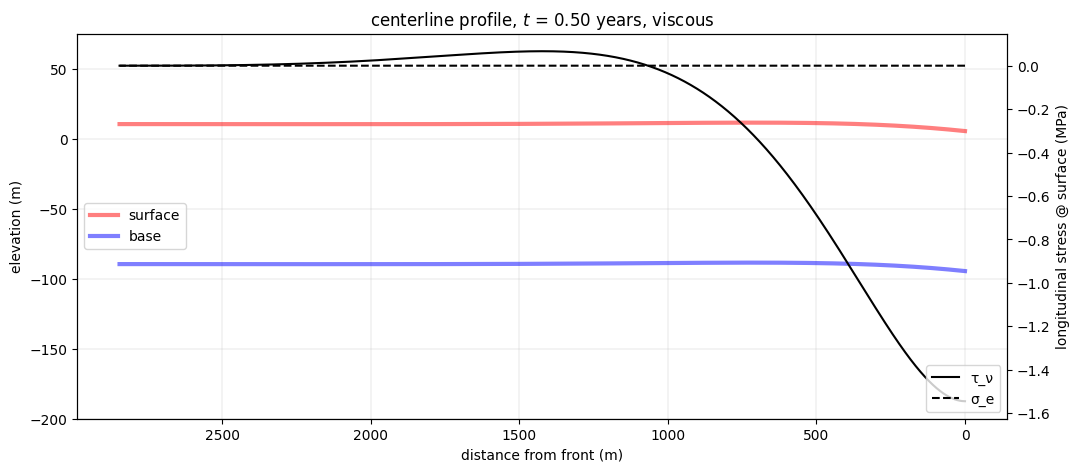

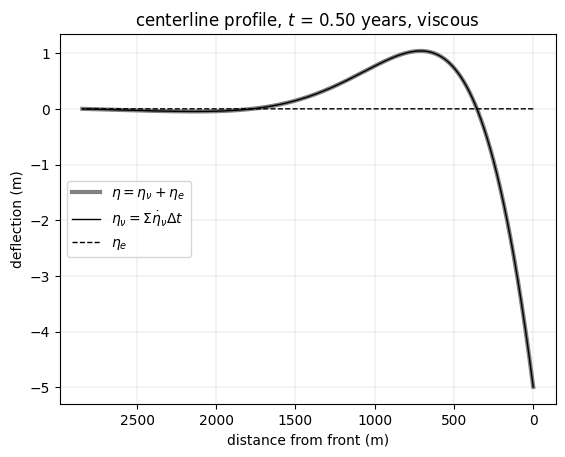

In [6]:
for step in tqdm.trange(num_timesteps): #just a single iteration for now, but keeping the code general

    #######################
    #######################
    ### elastic flexure ###
    #######################
    #######################
    
    if flexure_type in ['elastic']:
    
        f = -ρ_w*g*(η_e + Ση_e) #bouyancy force acting on the floating beam
    
        L = λ_1*H**3/12*inner(grad(grad(η_e + Ση_e)), ddw_e)*dx + λ_2*H**3/12*div(grad(η_e))*Δw_e*dx - f*w_e*dx #the flexure equation

        ################################
        ################################
        ## choose boundary conditions ##
        ################################
        ################################
        
        # boundary conditions on η:
        L += 0.5*α**2*(η_e + Ση_e)*w_e*ds(1)                                  #η(0) = 0
        L += 0.5*α**2*(η_e + Ση_e - η_0)*w_e*ds(2)                            #η(L) = η_0
        
        # boundary conditions on η'':
        L += 0.5*α**2*inner(grad(grad(η_e + Ση_e)), grad(grad(w_e)))*ds(1)    #η''(0) = 0

        # boundary conditions on η''':
        # These end up not being enforced at all!!!
        # L += 0.5*α**2*grad(grad(grad(η_e + Ση_e)))[0, 0, 0]*grad(grad(grad(w_e)))[0, 0, 0]*ds(2)     #η'''(L) = 0

        #this messy boundary condition acts as a stand-in for η'''(L) = 0
        L += 0.5*α**2*(grad(η_e + Ση_e)[0] - 2*D*(η_e + Ση_e)*(exp(D*Lx) + exp(-D*Lx))/(exp(D*Lx) - exp(-D*Lx)))*grad(w_e)[0]*ds(2)
        
        # boundary conditions in the lateral direction:
        L += 0.5*α**2*grad(η_e)[1]*grad(w_e)[1]*dx                            #dη/dy = 0 to ensure the problem is 1D-like
        
        solve(L == 0, η_e) #η_e is returned in meters
    
        #######################
        #######################
        ### adjust geometry ###
        #######################
        #######################
        
        b = Function(Q2).project(b + η_e) #b is modified by the deflection
        s = Function(Q2).project(s + η_e) #s is modified by deflection and surface mass balance 

    #######################
    #######################
    ### viscous flexure ###
    #######################
    #######################

    #ignore everything in this section for now 
    
    if flexure_type in ['viscous']:
    
        f = -ρ_w*g*(η_ν*Δt)
    
        L = 1/6*ν_flex*H**3*inner(grad(grad(η_ν)), ddw_ν)*dx + 1/6*ν_flex*H**3*div(grad(η_ν))*Δw_ν*dx - f*w_ν*dx #the viscous flexure equation

        # boundary conditions on η_ν:
        L += 0.5*α**2*η_ν*w_ν*ds(1)                                                             #η_ν(0) = 0
        L += 0.5*α**2*(η_ν - η_0/Δt)*w_ν*ds(2)                                                  #η_ν(L) = η_0/Δt
        
        # boundary conditions on η'':
        L += 0.5*α**2*inner(grad(grad(η_ν)), grad(grad(w_ν)))*ds(1)                             #η_ν''(0) = 0

        # boundary conditions on η''':
        # These end up not being enforced at all!!!
        # L += 0.5*α**2*grad(grad(grad(η_ν)))[0, 0, 0]*grad(grad(grad(w_ν)))[0, 0, 0]*ds(2)     #η_ν'''(L) = 0

        #this messy boundary condition acts as a stand-in for η_ν'''(L) = 0
        L += 0.5*α**2*(grad(η_ν)[0] - 2*D*η_0/Δt*(exp(D*Lx) + exp(-D*Lx))/(exp(D*Lx) - exp(-D*Lx)))*grad(w_ν)[0]*ds(2)
        
        # boundary conditions in the lateral direction:
        L += 0.5*α**2*grad(η_ν)[1]*grad(w_ν)[1]*dx                                              #dη/dy = 0 to ensure the problem is 1D-like
            
        solve(L == 0, η_ν) #η_ν is returned in meters per year
    
        #######################
        #######################
        ### adjust geometry ###
        #######################
        #######################
        
        b = b + η_ν*Δt #b is modified by the deflection
        s = s + η_ν*Δt #s is modified by deflection and surface mass balance 
                
    ##############################
    ##############################
    ### accumulate deflections ###
    ##############################
    ##############################

    Ση_νΔt = Function(Q2).project(Ση_νΔt + η_ν*Δt)
    Ση_e = Function(Q2).project(Ση_e + η_e)
    Ση = Function(Q2).project(Ση_e + Ση_νΔt)

    τ_ν = Function(Q2).project(-2*ν_flex*grad(grad(η_ν))[0, 0]*-H/2)
    σ_e = Function(Q2).project(H/2*λ_1*grad(grad(Ση_e))[0, 0] + H/2*λ_2*tr(grad(grad(Ση_e)))) 

    #################
    #################
    ### save figs ###
    #################
    #################
    
    #at each step, save plots of the surface and basal elevation profiles along "X"
    s_profile = np.array(project(s, Q2).at(X, tolerance = 1e-10))
    b_profile = np.array(project(b, Q2).at(X, tolerance = 1e-10))
    σ_e_profile = np.array(σ_e.at(X, tolerance = 1e-10))/1e6
    τ_ν_profile = np.array(τ_ν.at(X, tolerance = 1e-10))/1e6
    Σσ_profile = σ_e_profile + τ_ν_profile
    Ση_profile = np.array(Ση.at(X, tolerance = 1e-10))
    Ση_e_profile = np.array(Ση_e.at(X, tolerance = 1e-10))
    Ση_νΔt_profile = np.array(Ση_νΔt.at(X, tolerance = 1e-10))
    
    plt.figure(figsize = (12, 5))
    plt.title(f'centerline profile, $t$ = {step*Δt + Δt:.2f} years, {flexure_type}')
    plt.xlabel('distance from front (m)')
    plt.ylabel('elevation (m)')
    plt.plot(s_profile[::-1], color='red', label = 'surface', linewidth = 3, alpha = 0.5)
    plt.plot(b_profile[::-1], color='blue', label = 'base', linewidth = 3, alpha = 0.5)
    plt.gca().invert_xaxis()
    plt.legend(loc = 'center left')
    plt.ylim(-200, 75) 
    plt.grid(linewidth=0.2)
    plt.twinx()
    plt.plot(τ_ν_profile[::-1], color = 'k', linestyle = 'solid', label = 'τ_ν')
    plt.plot(σ_e_profile[::-1], color = 'k', linestyle = 'dashed', label = 'σ_e')
    plt.legend(loc = 'lower right')
    plt.ylabel('longitudinal stress @ surface (MPa)')
    # plt.ylim(-0.25, 0.25)
    plt.savefig('iteration_{}'.format(step + 1))
    if step < num_timesteps - 1:
        plt.close() #save all plots but only show the last iteration

    plt.figure()
    plt.title(f'centerline profile, $t$ = {step*Δt + Δt:.2f} years, {flexure_type}')
    plt.xlabel('distance from front (m)')
    plt.ylabel('deflection (m)')
    plt.plot(Ση_profile[::-1], color = 'grey', linestyle = 'solid', linewidth = 3, label = '$η = η_ν + η_e$')
    plt.plot(Ση_νΔt_profile[::-1], color = 'k', linestyle = 'solid', linewidth = 1, label = '$η_ν = Σ\dot{η}_νΔt$', zorder = 100)
    plt.plot(Ση_e_profile[::-1], color = 'k', linestyle = 'dashed', linewidth = 1, label = '$η_e$', zorder = 100)
    plt.gca().invert_xaxis()
    plt.legend(loc = 'center left')
    # plt.ylim(-10, 40)
    plt.grid(linewidth=0.2)
    plt.savefig('deflection_iteration_{}'.format(step + 1))
    if step < num_timesteps - 1:
        plt.close() #save all plots but only show the last iteration

## Compare solutions

Text(0, 0.5, 'difference between deflection solutions')

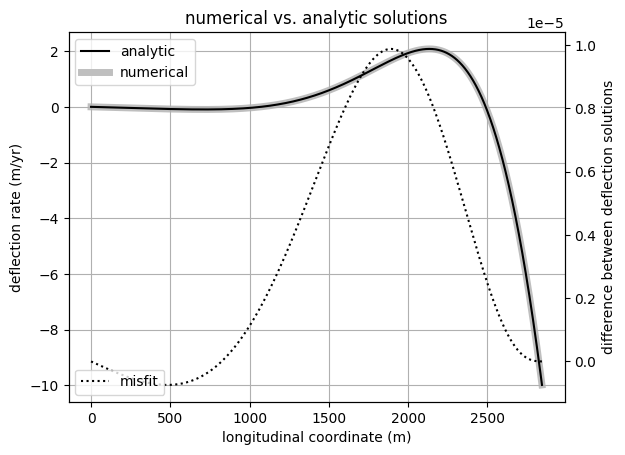

In [7]:
numerical = Function(Q2).project(η_e) if flexure_type == 'elastic' else Function(Q2).project(η_ν)
numerical_profile = np.array(numerical.at(X, tolerance = 1e-10))

plt.figure()
plt.title('numerical vs. analytic solutions')
plt.plot(analytic_profile, color = 'k', label = 'analytic')
plt.plot(numerical_profile, color = '0.75', linewidth = 5, zorder = 0, label = 'numerical')
plt.legend(loc = 'upper left')
plt.grid()
plt.xlabel('longitudinal coordinate (m)')
if flexure_type == 'elastic':
    plt.ylabel('deflection (m)')
else:
    plt.ylabel('deflection rate (m/yr)')
plt.twinx()
plt.plot((analytic_profile - numerical_profile), color = 'k', linestyle = 'dotted', label = 'misfit')
plt.legend(loc = 'lower left')
plt.ylabel('difference between deflection solutions')